# Tutorial 1: Energy formulation for the phase field model


In [140]:
# These import commands are always necessray 
import numpy as np    # import the numerical python module
from numpy import pi  # so we can address np.pi simply as pi

import matplotlib.pyplot as plt # import the standard plotting module

%matplotlib notebook
# %matplotlib inline
#     "notebook " creates a more versatile plot window
#     "inline " is the default plot window

import matplotlib

# adjust font size for all plots
#font = {'family' : 'normal',
#        'weight' : 'normal',
#        'size'   : 18}
#matplotlib.rc('font', **font)

## Some necessary NumPy constructs:

For the numerical solution of PDEs we need NUmPy arrays and the knowledge to access subsets of their contents.
This is done by index  operations:

In [3]:
a = np.linspace(0, 10, 11) # create a 1D array (our 'grid') with 11 points / 10 sections 
a

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [4]:
a[-1] # the last element

10.0

In [5]:
a[1:-1] # index operations, useful for e.g. efficient computations
        # this here cuts away first and last element

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [6]:
a = np.array([1,2,3,4,5])
b = a
a[0] = 100
a, b  # you see: arrays are not copied by = operator, but just point to their reference object

(array([100,   2,   3,   4,   5]), array([100,   2,   3,   4,   5]))

In [19]:
# This is the way to copy an array
b = a.copy() # or: b = np.copy(a)
a[:] = 0.0
a, b

0
1
2
3
4
5
6
7
8
9


# The equilibrium phase-field model (model A)

The free energy functional defines the energy in the simulation domain $\Omega$. In the phase-field method consists of (at least) two contributions: the gradient energy and the (double well) potential:
\begin{equation}
\mathcal{F} = \int_{\omega} \Big\{ \frac{1}{2} K \left( \nabla \Psi \right)^2 + H f_{dw}(\Psi) \Big\} dV
\end{equation}

## Double well potential

This double well potential $f_{dw}$ has been adapted, so that at the minima the potential is exactly 0.

In [8]:
def f_dw(x):
    return -x**2/2 + x**4/4 + 1/4

def df_dw(x):
    return -x + x**3

f_dw(1.0), f_dw(-1)

(0.0, 0.0)

<IPython.core.display.Javascript object>


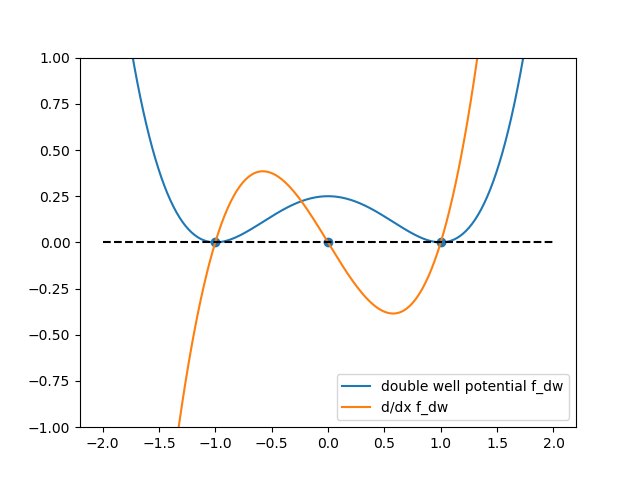

In [16]:
X = np.linspace(-2,2,300)

plt.plot(X,f_dw(X),  label='double well potential f_dw')
plt.plot(X,df_dw(X), label='d/dx f_dw')
plt.plot(X,0.0*df_dw(X),'k--')
plt.scatter([-1,1,0],[0,0,0]) # plot three points from two coordinate lists
plt.ylim(-1,1)
plt.legend()
plt.show()

## 1. Numerical solution

The diffusion-reaction equation 
$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2} + g(x,t) \quad (1)$$
is defined on the interval $[0, L]$, which is discretized ny $N$ grid points.
In the FCTS scheme we will discretize the time derivative with forward differences, the Laplacian (second spatial derivatives) with the central difference stencil. 

In this way, Eq. (1) can be solved with a fully explicit algorithm without assembling a system of equations for all grid points. As an example, boundary conditions are isolation (special Neumann BC, i.e. $\frac{\partial u}{\partial x} = 0|_{x=L}$) at the right and a predefined value (Dirichlet BC) at the left boundary.

The new value at time $n+1$ is then given by iterating 
$$u_i^{n+1} = u_i^n + \Delta t \left[ \frac{\kappa}{{\Delta x}^2} (u_{i+1}^n-2 u_i^n + u_{i-1}^n) + g_i^n\right]$$
over all grid points, from the discrete BCs we get the following boundary values

$$u_0^n = s(t_n)\\
u_N^{n+1} = u_N^n + \Delta t \left[ \frac{\kappa}{{\Delta x}^2} (2 \Delta x u_{i+1}^n -2 u_N^n + u_{N-1}^n) + g_i^n\right]$$

The last equation is a second order accurate method introducing a 'ghost point' outside the domain, a simpler (but less accurate) way would be to use backward differences, giving $u_N^{n+1} = u_N^n $.

**Stability** The explicit forward Euler scheme imposes a stability criterion on the selection of time steps widths:
$$\Delta t \le\frac{\Delta x^2}{2 d \kappa} \mbox{ where } d \mbox{ is the dimension of the problem: 1,2,3 }$$

### FCTS scheme for the phase-field equation (forward in time, central in space)

We know now what to do. The evolution equation for the equilibrium phase-field model A (1 D) is exactly of the form of Eq, (1),
$$\frac{\partial \Psi}{\partial t} = \Gamma \left( K \frac{\partial^2 \Psi}{\partial x^2} + H f'_{dw}(x,t) \right) \quad (2),$$
where $\Gamma K$ constitutes the diffusion coefficient and $\Gamma H f'_{dw}(x,t)$ the source term.


stability limit: 0.5


<IPython.core.display.Javascript object>


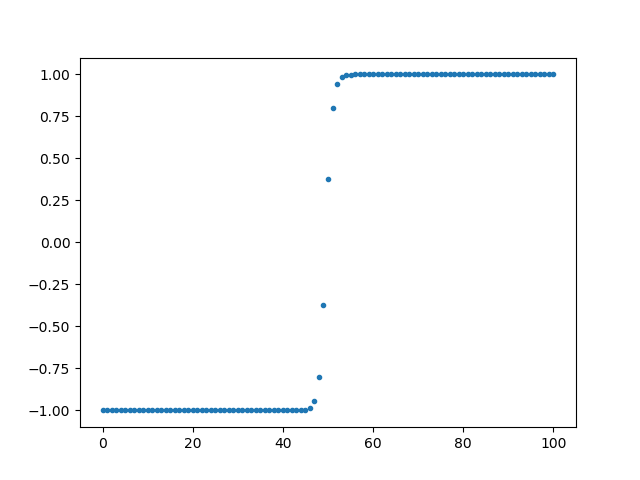

In [72]:
# Model parameters --------------------------------------------
K = 1.0  # gradient energy coefficient
H = 1.0  # potential energy coefficient
Gamma = 1.0 # mobility parameter

# Numerical setup ---------------------------------------------
N = 101
x = np.linspace(0, 100, N)
dx = x[1]-x[0]

steps = 100
delta_t = dx**2/(2*Gamma*K) # stable time step of the FCTS scheme
print('stability limit:', delta_t)
m = 0.5
delta_t = m*delta_t
t = np.linspace(0, steps*delta_t, 
                N)


# Initial condition -------------------------------------------
psi0 = -np.ones(N)
#psi0  = np.zeros(N) # create & initialize psi0 array with -1
psi0[N//2:] = 1.0   # set psi0 to 1 for half of the domain

psi  =  np.zeros(N) # the array for the update


# The time loop -----------------------------------------------
for t in range(steps):
    for i in range(1,N-1):
        tmp = -K*(psi0[i+1] - 2*psi0[i] + psi0[i-1])/dx**2 + H*df_dw(psi0[i])
        psi[i] = psi0[i] - Gamma*delta_t*tmp
        
        psi[0] = psi[1]     # Neumann condition at left 
        psi[N-1] = psi[N-2] # and right boundary. Note that N = 101 while the index on the right boundary is 100.
    psi0 = np.copy(psi) # buffer actual time step
    
# Plot the result ---------------------------------------------
plt.plot(x,psi,'.') # just the final time step ...
plt.show()

### <font color='red'>TASK</font> Effect of gradient energy and potential

Increase the parameters $K$ and $H$ to check the influence of either energy term!

### Answer: 
- Increase of K leads to a wider(diffusiver) interface.
- Increase of H leads to a narrower interface.

### <font color='red'>TASK</font> Choice of time step width

Try different values of the time step `delta_t`. especially around the critical step width $\Delta x^2 / (2 \Gamma K)$. 

### Answer:
- Stable below 0.7*critical step width.
- Shown results between 0.7~1.0, but quite random.
- Blank above 1.0.

### <font color='blue'>METHOD </font> Vectorized computation for better efficiency


Optimized numerical calculations on arrays in NumPy can improve the speed of the code massively.

Using the index operations you can quickly combine complete arrays in one step. In the expression $u[a:b]$ the colon in the square brackets separates the start element ($a$) from the end element ($b-1$): If $a$ or $b$ is missing, NumPy by default assumes the first or very last element of the array. Try it out!

Here you see how to compute the 3-point stencil for the second FD derivative:
$$ \mbox{for } i \in (0, \dots, N-1): u_{i+1} - 2 u_i + u_{i+1} = u[:-2] – 2 u[1:-1] + u[2:] $$

The following image tries to explain this term: with the indexing $u[2:]$ you shift the whole array two positions downwards, with $u[:-2]$ two positions upwards. $u[1:-1]$ is the 'unshifted array', cropped for 1 element on either sides.
<img src="vectorized.png" width="400" >

In the same manner (assuming $\Delta x = \Delta y$) you get the FD Laplacian five-point stencil in 2D as
$$u_{i+1,j} + u_{i,j+1} - 4 u_{i,j} + u_{i-1,j} + u_{i,j-1} =
			u[:-2,1:-1] + u[:,:-2] - 4 u[1:-1,1:-1] + u[2:,1:-1] + u[:,2:]$$

(more details
[here](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html) )



## 2. Vectorized computation of the 1D phase-field equation

The same code as above with changes only in the computation of the update:

stability limit: 0.05


<IPython.core.display.Javascript object>


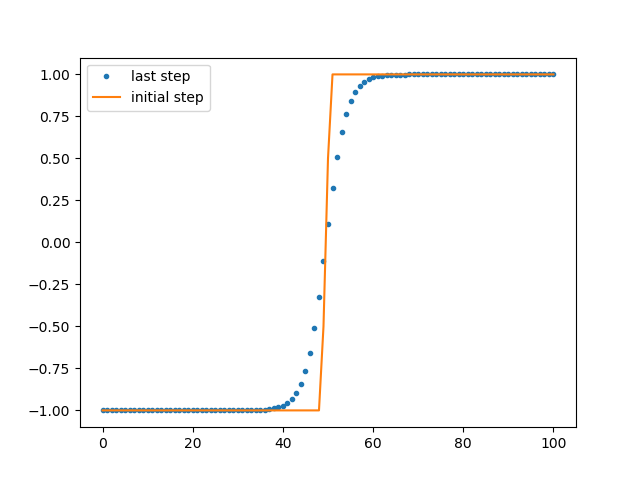

In [89]:
# Model parameters --------------------------------------------
K = 10.0  # gradient energy coefficient
H = 1.0  # potential energy coefficient
Gamma = 1.0 # mobility parameter

# Numerical setup ---------------------------------------------
N = 101
x = np.linspace(0, 100, N)
dx = x[1]-x[0]

steps = 500
delta_t = dx**2/(2*Gamma*K) # stable time step of the FCTS scheme
print('stability limit:', delta_t)
delta_t = 0.5*delta_t
t = np.linspace(0, steps*delta_t, N)


# Initial condition -------------------------------------------
psi0  = -np.ones(N) # create & initialize psi0 array with -1
psi0[N//2:] = 1.0   # set psi0 to 1 for half of the domain

psi =  np.zeros(N)  # the array for the update
psi_sav = np.zeros((steps,N)) # a (steps x N) array to store all steps

# The time loop -----------------------------------------------
for l in range(steps):
    # HERE ARE THE CHANGES ===================================================
    tmp = -K*(psi0[2:] - 2*psi0[1:-1] + psi0[:-2])/dx**2 + H*df_dw(psi0[1:-1])
    psi[1:-1] = psi0[1:-1] - Gamma*delta_t*tmp
    # ========================================================================
    
    psi[0] = psi[1]     # Neumann condition at left
    psi[N-1] = psi[N-2] # and right boundary
    
    psi0 = np.copy(psi) # buffer actual time step
    
    psi_sav[l,:] = psi  # store result as another frame

    
# Plot the result --------------------------------------------
plt.plot(x,psi,'.', label='last step')      # just the final time step ...
plt.plot(x,psi_sav[0,:], label='initial step') # and the initial
plt.legend()
plt.show()

# Some analysis of the interface profile

A simple plot of the two energy density contributions (gradient energy, potential) shows, where the energy is located:
At the interface, with both contributions being identical for the analytical solution.

In [76]:
# energy density contributions
grad_psi = np.zeros(N)
grad_psi[1:-1] = (psi[2:] - psi[:-2])/(2*dx) # calculate derivative with central differences

plt.plot(x, 0.5*K*grad_psi**2, '.-', label='gradient energy')
plt.plot(x, H*f_dw(psi), label='potential')
plt.plot(x, 0.5*K*grad_psi**2+H*f_dw(psi), label='total energy')
plt.legend()
plt.show()

## Interface free energy

The interface free energy $\gamma$ is defined integrating all the energy density terms of the free energy functional along one coordinate through the interface, and the subtracting the integrated bulk term (the potential $f_{dw}$).
As $f_{dw}$ vanishes in the bulk phases ($\psi = \pm 1$) for the potential used here, this subtracted part is zero anyway.

For numerical integration, we use the Python methods from the SciPy module. Here the Simpson rule is chosen, where the data set is divided into sections of three data points, that are connected via a parabola and are integrated, and the result summed up for all.

In [77]:
# integrate energy over domain -> surface free energy (surface tension)
from scipy import integrate
y = 0.5*K*grad_psi**2 + f_dw(psi)

integrate.simps(y,x) # Simpson's rule for integrating data points (x,y)

2.961531785432984

In [78]:
2*np.sqrt(2)/3*np.sqrt(K*H) # The analytical result

2.98142396999972

## Interface profile

The interface profile of the phase-field parameter will take a $tanh()$ shape. Now we can fit our simulated profile to this function, where the width $w$ and the interfave location $x_0$ serve as fitting parameters.

In [79]:
from scipy.optimize import curve_fit

def func(x, x0, w):
    return np.tanh((x-x0)/w)

params, params_cov = curve_fit(func, x, psi)
#params, params_cov = curve_fit(func, x, psi, p0=[50, 1]) # starting values (p0=) in case the fit doesn't converge

# params[0] : parameter x0
# params[1] : parameter w

In [80]:
plt.plot(x, psi, 'o')
plt.plot(x, func(x, *params), 'g--', label='fit: w=%f' % (params[1]))
plt.legend()
plt.show()

In [81]:
params[1], np.sqrt(2*K/H) # compare both widths

(4.451390969011487, 4.47213595499958)

### <font color='red'>TASK</font> Dependency on grid resolution

Repeat the simulation with different interface widths $\sqrt{2 K/H}$ by changing K and/or H! Calculate for each the interface energy and the equilibrium profile as done above!

### Method: 
Change the value of K and H in the block "Vectorized solution" and run the following blocks.

# Animation of time evolution

Carry out the last simulation - the data should be then in the array `psi_sav[]`.

Under Linux everything should work directly. If you use Windows, for saving the movies you need to install the [FFMPEG](https://ffmpeg.org/) tool for graphics conversion and movie generation. Or you can always use 'xy.gif' as file name to generate an animated gif.

<IPython.core.display.Javascript object>


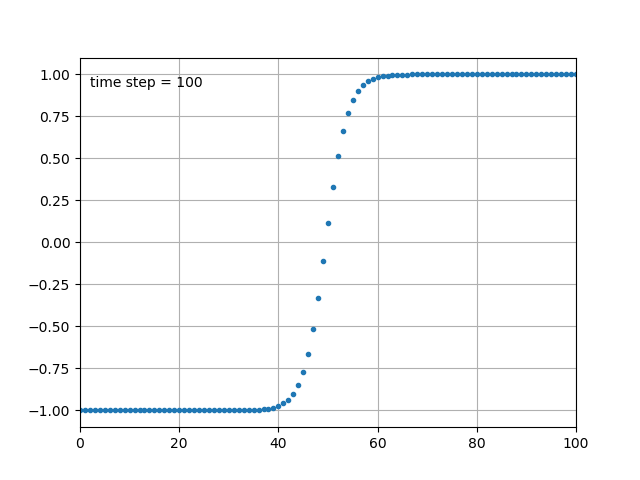

In [82]:
# create animated plot ----------------------------------------------------

from matplotlib import animation
fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(-1.1, 1.1))
ax.grid()

line, = ax.plot([], [], '.', lw=2)
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes)


N_ani = 1
def animate(i):  # This function controls the update of the plot
    global psi_sav, x, t

    time_text.set_text('time step = %d' % (N_ani*i))
    line.set_data(x, psi_sav[N_ani*i,])
    return line,

numFrames = 100 # the number of the first frames to create the animation from
anim = animation.FuncAnimation(fig, animate,frames=int(t.size/N_ani), interval=numFrames, blit=True, repeat=False)
#anim.save('psi_1D_unstable.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=300) # save as mp4 movie, Linux
#anim.save('psi_1D_unstable.gif', fps=15, dpi=300) # works under windows, maybe other formats possible

plt.show()

### <font color='red'>TASK</font> Phase-field in 2D

Try to extend the (original or vectorized) 1D code from above to two dimensions! Verify, that the only change in the phase-field equation appears in the definition of the second derivative, which now becomes a Laplacian:
$$ \frac{\partial^2 \Psi}{\partial x^2} \to \frac{\partial^2 \Psi}{\partial x^2} + \frac{\partial^2 \Psi}{\partial y^2}$$
Use the fact that the new derivative in $y$ can be discretized in the same way as in $x$. In the vectorized code, there are now two indices to take care of...

Filling a rectangular of half the simulation box will give a situation completely identical to the 1D case before (same psi profile etc.). Try to set a circular domain as initial condition and look what happens (simulation will need many time steps).

**Hint:** To visualize the 2D data, use the MatPlotLib command `imshow`. Here below is an example (the content of the array is arbitrary): 

In [138]:
# Phase-field in 2D -------------------------------------------

# Energy functions --------------------------------------------
def f_dw(x):
    return -x**2/2 + x**4/4 + 1/4

def df_dw(x):
    return -x + x**3

# Model parameters --------------------------------------------
K = 10.0  # gradient energy coefficient
H = 1.0  # potential energy coefficient
Gamma = 1.0 # mobility parameter

# Numerical setup ---------------------------------------------
N = 101
x = np.linspace(0, 100, N)
y = np.linspace(0, 100, N)
dx = x[1]-x[0]
dy = y[1]-y[0]

steps = 10000
delta_t = dx**2/(2*Gamma*K) # stable time step of the FCTS scheme
print('stability limit:', delta_t)
delta_t = 0.05*delta_t
t = np.linspace(0, steps*delta_t, N)
# Have to reduce delta_t from 0.5 to 0.1, otherwise fluctuation occurs.


# Initial condition with random values-------------------------------------------
#psi0  = -np.ones([N, N]) # create & initialize psi0 array with -1
#psi0[N//2:, N//2:] = 1.0   # set psi0 to 1 for half of the domain
#psi0[:N//2, :N//2] = 1.0
psi0 = np.random.randn(N,N)


psi_ini = np.copy(psi0)

psi = np.zeros([N, N])  # the array for the update
psi_sav = np.zeros([steps,N,N]) # a (steps x N) array to store all steps

# The time loop -----------------------------------------------
for l in range(steps):
    # HERE ARE THE CHANGES ===================================================
    tmp = -K*((psi0[2:, 1:-1] - 2*psi0[1:-1, 1:-1] + psi0[:-2, 1:-1])/dx**2 
              + (psi0[1:-1, 2:] - 2*psi0[1:-1, 1:-1] + psi0[1:-1, :-2])/dx**2) + H*df_dw(psi0[1:-1, 1:-1])
    psi[1:-1, 1:-1] = psi0[1:-1, 1:-1] - Gamma*delta_t*tmp
    # ========================================================================
    
    psi[0, :] = psi[1, :]     # Neumann condition at left
    psi[N-1, :] = psi[N-2, :]# and right boundary
    psi[:, 0] = psi[:, 1]
    psi[:, N-1] = psi[:, N-2]
    
    psi0 = np.copy(psi) # buffer actual time step
    
    psi_sav[l,:,:] = psi  # store result as another frame

    
# Plot the result --------------------------------------------
#plt.plot(x,psi,'.', label='last step')      # just the final time step ...
#plt.plot(x,psi_sav[0,:], label='initial step') # and the initial
#plt.legend()
#plt.show()'''
plt.imshow(psi)
plt.colorbar()
#plt.imshow(psi_ini)

stability limit: 0.02222222222222222


<IPython.core.display.Javascript object>


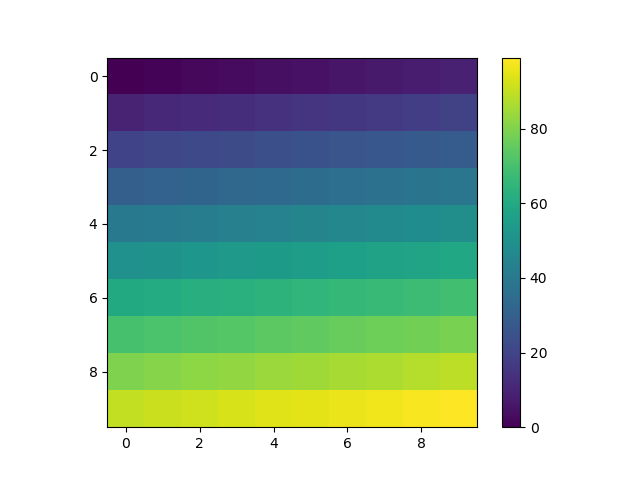

In [102]:
a = [] # empty object
N = 10
for i in range(N):
    a.append(np.arange(N*i, N*(i+1))) # create sequence of increasing numbers, each N give a new row

plt.imshow(a)   # print 2D array as pixel pattern
#plt.imshow(a, cmap='hot') # some color
#plt.imshow(a, cmap='gray')# variations
plt.colorbar()  # ...
plt.show()

In [ ]:
# Here the 2D phase-field code ...

<IPython.core.display.Javascript object>


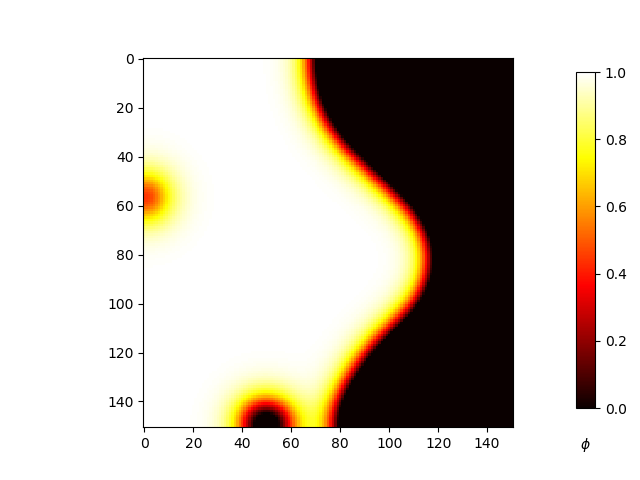

In [139]:
# Animation in 2D
# assumes, that you have stored the simulation frames in the 3-index array
# psi_sav = np.zeros((steps,N,N))
#    steps: number of frames
#    N    : grid points in x and y

from matplotlib import animation
# create starting image for animation
fig, ax = plt.subplots()
im = ax.imshow(psi_sav[0,], cmap=plt.get_cmap('hot'), vmin=0, vmax=1, animated=True)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$\phi$', labelpad=20)
fig.colorbar(im, cax=cbar_ax)


def animate(i, *args):
    """Update frame i fo the animation"""
    global psi_sav
    #u = do_timestep_vector(u0, u, i)
    im.set_array(psi_sav[i*s,])
    #ax.set_title('{:.1f} ms'.format(i*dt))
    
    #time.sleep(0.2)
    return im,

s = 10 # take every s(th) frame for animation
anim = animation.FuncAnimation(fig, animate, frames=steps//s, interval=10, blit=True, repeat=False)

# see animation
plt.show()

# save animation as movie
#anim.save(filename='phasefield2D.gif', writer='imagemagick', fps=30, dpi=300)

### <font color='blue'>METHOD: Excursion - </font> Pseudo Random Numbers

Random numbers are important for quite a number of tasks in scientific computing, e.g. in Monte Carlo methods, for the approximation of integrals or to model statistic processes. Computer can't - with a few exceptions - create real random numbers.

**Random number generators (RNGs)** are programs that create a series of pseudo-random integers. This sequence is in fact deterministic, and is initialized with a starting value (seed), which can be changed to produce a different sequence.
Most RNGs rely on iterative integer operations, namely multiplication and modulo division of (large) integer numbers ($x_i, a, c, m$):

$x_{i+1} = (a \cdot x_i + c) \, mod \, m$

Modulo is realized in Python with the operator `%`. Every initial value $x_0$ (= seed) creates another reproducible sequence $x_i, i \in \{0, \dots m-1\}$, hence the term pseudo random numbers. Real numbers can simply generated from the intergers by dividing by the modulus:

$x_i^{float} = x_i/m$

The created sequence must pass statistic tests sufficiently well, i.e. the numbers need to be uniformly distributed in the interval $[0, 1)$.


### Built-in Random Number Generator in NumPy 

Instead of coding our own generator (which is pretty simple), we use the built-in RNGs in NumPy form the NumPy submodule `np.random`, which are already imported.

Python uses the [**Mersenne-Twister**](https://en.wikipedia.org/wiki/Mersenne_Twister) as the standard generator. Based on several starting values in binary representation a statistically 'random' number sequence is produced by binary operations and modulo divisions, with an extremely long repetition period of $2^{19937} -1 \approx 4.3 \times 10^{6001}$. This means in practice that there is no repetition within a program execution.


**Seed:** determines specific sequence of 'random' numbers. Fixing a seed always creates the same sequence, which is beneficial for development & debugging. If you don't a value generated from the internal clock is used to start every time with different numbers.

In [107]:
from numpy.random import random, seed
seed(123) # initialize pseudo random sequence
['%.2f' % random() for i in range(7)]

['0.70', '0.29', '0.23', '0.55', '0.72', '0.42', '0.98']

In [108]:
seed(123) 
['%.2f' % random() for i in range(7)]

['0.70', '0.29', '0.23', '0.55', '0.72', '0.42', '0.98']

In [ ]:
['%.2f' % random() for i in range(7)]

**Distributions:** `np.random` creates float numbers with uniform distribution between 0 and 1. Often 

Often, normal distributions (Gaussian) values are important, sometime exponential and lognormal distributions are desired:

In [ ]:
from numpy.random import normal, uniform, exponential, randint

seq = uniform(-1,1,6000) # array with 6000 uniformly distributed numbers

mu, sigma = 0, 0.1 # average, standard deviation of the Gaussian distribution
seq = normal(mu, sigma, 6000) # create 6000 normal distributed numbers

In [ ]:
plt.plot(seq, '.', markersize=1)
plt.show()

In [ ]:
b = uniform(-1,1,1000)
plt.plot(b, '.', markersize=1)
plt.show()

In [ ]:
# randint(-1,2,(10,10))

### <font color='red'>TASK</font> Random initial condition

Use the 2D phase-field code and modifiy it by creating an initial condition with phase-field value (magnetization) randomly assuming values between -1 and 1 (discrete or continous).

What happens, and what is the driving force?

In [123]:
# Initial condition
def initialCond(psi0, N):
    """Random initial filling"""
    psi0 = np.random.randn(N,N) # new code here ...
    return psi0

# the same 2D PF code as before here ...

<IPython.core.display.Javascript object>


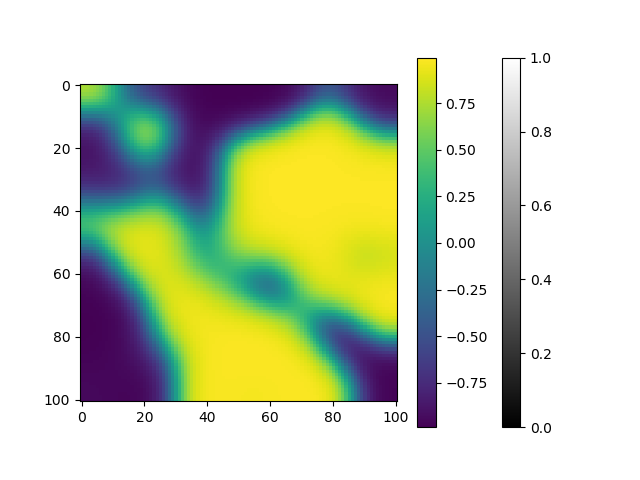

In [124]:
plt.imshow(psi_sav[160,], cmap = 'gray', vmin=0, vmax=1)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


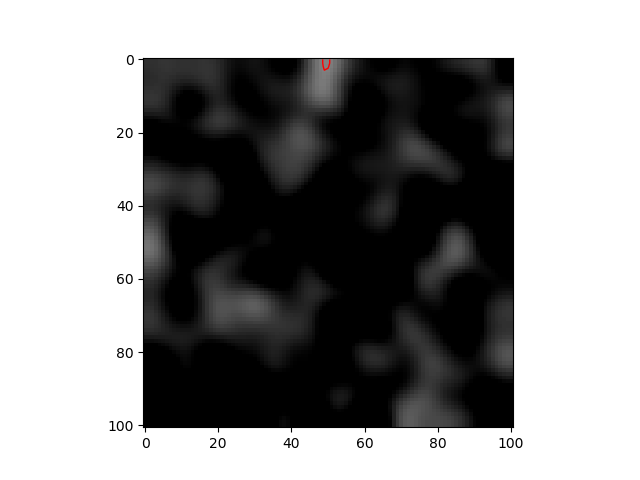

In [128]:
L = 100
x = np.linspace(0.0, L, N)
y = np.linspace(0.0, L, N)
X, Y = np.meshgrid(x, y)
plt.imshow(psi_sav[160,], cmap = 'gray', vmin=0, vmax=1)
cs = plt.contour(X,Y,psi_sav[160,], levels=[0.5], colors=['red'], linewidths=1)
plt.show()

<IPython.core.display.Javascript object>


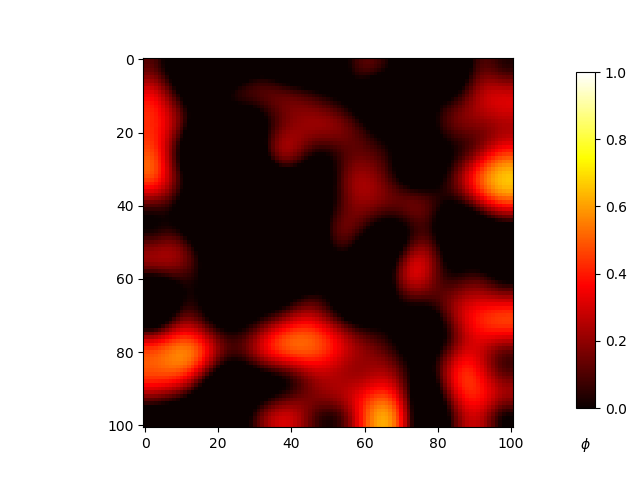

In [132]:
# Animation in 2D
# assumes, that you have stored the simulation frames in the 3-index array
# psi_sav = np.zeros((steps,N,N))
#    steps: number of frames
#    N    : grid points in x and y

# create starting image for animation
fig, ax = plt.subplots()
im = ax.imshow(psi_sav[0,], cmap=plt.get_cmap('hot'), vmin=0, vmax=1, animated=True)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$\phi$', labelpad=20)
fig.colorbar(im, cax=cbar_ax)


def animate(i, *args):
    """Update frame i fo the animation"""
    global psi_sav
    #u = do_timestep_vector(u0, u, i)
    im.set_array(psi_sav[i*s,])
    #ax.set_title('{:.1f} ms'.format(i*dt))
    
    #time.sleep(0.2)
    return im,

s = 5 # take every s(th) frame for animation
anim = animation.FuncAnimation(fig, animate, frames=steps//s, interval=100, blit=True, repeat=False)

# see animation
plt.show()

# save animation as movie
#anim.save(filename='phasefield2D.gif', writer='imagemagick', fps=30, dpi=300)